# Creating Test Datasets

## Loading the Data

In [1]:
import math
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn import datasets as D
from scipy.spatial import distance_matrix

from pyspark.sql import SparkSession
import pyspark.sql.functions as F

In [2]:
# the total nr of points inside the sample dataset
N_SAMPLES = 1500

noisy_circles = D.make_circles(n_samples=N_SAMPLES, factor=.5, noise=.05)
noisy_circles

(array([[ 0.30675144,  0.4558819 ],
        [ 0.54967942, -0.04425099],
        [-0.32015472,  0.92469641],
        ...,
        [ 0.30679413, -0.21607956],
        [ 0.18794117,  0.5101737 ],
        [-0.06248552,  0.52266835]]),
 array([1, 1, 0, ..., 1, 1, 1]))

In [3]:
def sklearn_scatter_to_df(sklearn_scatter_data):
    return pd.DataFrame(data={
        'x': [sklearn_scatter_data[0][i][0] for i in range(len(sklearn_scatter_data[0]))],
        'y': [sklearn_scatter_data[0][i][1] for i in range(len(sklearn_scatter_data[0]))],
        'cluster': [sklearn_scatter_data[1][i] for i in range(len(sklearn_scatter_data[0]))]
    })

<Axes: xlabel='x', ylabel='y'>

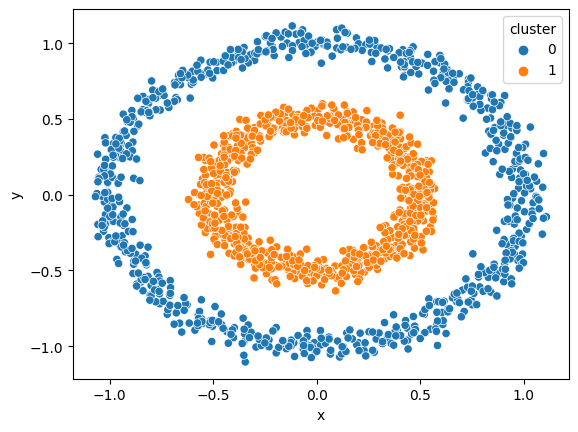

In [4]:
sns.scatterplot(sklearn_scatter_to_df(noisy_circles), x='x', y='y', hue='cluster')

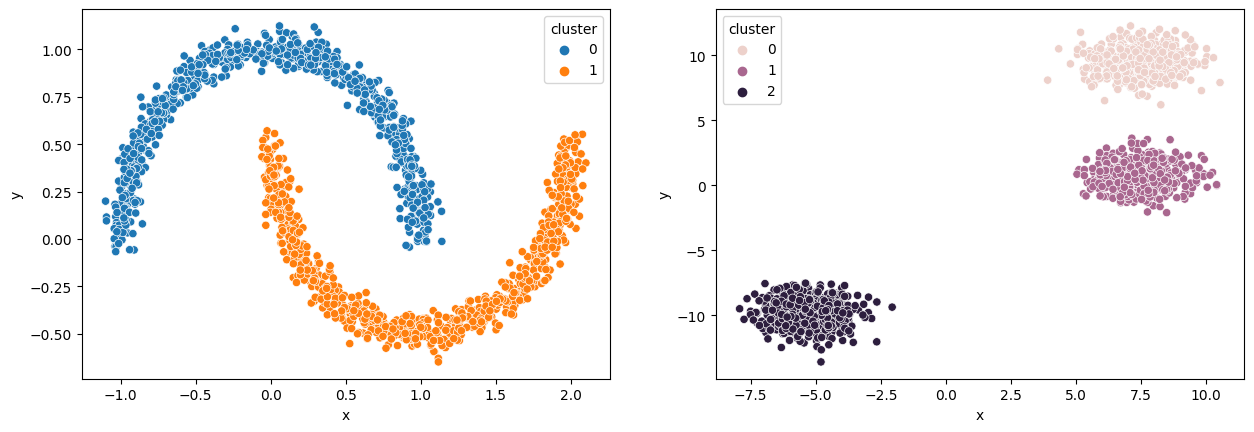

In [5]:
noisy_moons = D.make_moons(n_samples=N_SAMPLES, noise=0.05)
blobs = D.make_blobs(n_samples=N_SAMPLES, random_state=8)

fig, axs = plt.subplots(ncols=2)

sns.scatterplot(sklearn_scatter_to_df(noisy_moons), x='x', y='y', hue='cluster', ax=axs[0])
sns.scatterplot(sklearn_scatter_to_df(blobs), x='x', y='y', hue='cluster', ax=axs[1])

fig.set_figwidth(15)

## Creating the Distance Matrix

In [6]:
class UndirectedWeightedGraph:
    def __init__(self, edge_weights, vertices):
        self.__edge_weights = edge_weights
        self.__vertices = vertices
        
    def vertices(self):
        # copy?
        return self.__vertices
        
    def weight(self, v1, v2):
        if v1 < v2 and v1 in self.__edge_weights and v2 in self.__edge_weights[v1]:
            return self.__edge_weights[v1][v2]
        elif v2 < v1 and v2 in self.__edge_weights and v1 in self.__edge_weights[v2]:
            return self.__edge_weights[v2][v1]
        else:
            return math.inf
        
    def neighbourhood(self, vertex):
        n = []
        
        if vertex in self.__edge_weights.keys():
            for v in self.__edge_weights[vertex].keys():
                n.append((v, self.__edge_weights[vertex][v]))

        for v in range(vertex):
            if v in self.__edge_weights.keys() and vertex in self.__edge_weights[v].keys():
                n.append((v, self.__edge_weights[v][vertex]))
                
        return n

In [7]:
d_matrix = distance_matrix(noisy_circles[0], noisy_circles[0], threshold=1000000)
d_matrix

array([[0.        , 0.55600981, 0.7828144 , ..., 0.67196145, 0.13062725,
        0.37522841],
       [0.55600981, 0.        , 1.30210233, ..., 0.29752029, 0.66199795,
        0.83435211],
       [0.7828144 , 1.30210233, 0.        , ..., 1.30170452, 0.65573662,
        0.47751438],
       ...,
       [0.67196145, 0.29752029, 1.30170452, ..., 0.        , 0.73591427,
        0.82590309],
       [0.13062725, 0.66199795, 0.65573662, ..., 0.73591427, 0.        ,
        0.2507382 ],
       [0.37522841, 0.83435211, 0.47751438, ..., 0.82590309, 0.2507382 ,
        0.        ]])

In [8]:
# convert the distance matrix to edge dict:
edges = {}
for i in range(len(d_matrix[0])):
    edges_vertex = {}
    for j in range(i + 1, len(d_matrix[0])):
        edges_vertex[j] = d_matrix[i][j]
    edges[i] = edges_vertex

In [9]:
graph = UndirectedWeightedGraph(edges, [i for i in range(len(noisy_circles[0]))])

In [10]:
graph.weight(2, 5)

1.911995553825595

# The Affinity Clustering Algorithm

In [11]:
spark = (SparkSession
    .builder
    .appName("Affinity Clustering")
    .getOrCreate())

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/12/05 15:22:22 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [12]:
sc = spark.sparkContext
sc

<SparkContext master=local[*] appName=Affinity Clustering>

In [13]:
def find_best_neighbor_map(x):
    vertex, neighbourhood = x
    return (vertex, min(neighbourhood, key=lambda n:n[1])[0])

def find_best_neighbor_mpc(graph):
    findbestneighbors_input = [(v, graph.neighbourhood(v)) for v in graph.vertices()]

    best_neighbors = (sc.parallelize(findbestneighbors_input)
        .map(lambda x: find_best_neighbor_map(x))
        .collect())
    
    best_neighbor_m = {}
    for vertex, neighbor in best_neighbors:
        best_neighbor_m[vertex] = neighbor
        
    return best_neighbor_m

In [14]:
# not efficient, can be combined with contraction_mpc_map
# still doing it like this for clarity
def find_leader_map(x, best_neighbor_m):
    vertex, neighbourhood = x
    c = vertex
    v = vertex
    S = []
    
    while v not in S:
        S.append(v)
        c = min(c, v)
        v = best_neighbor_m[v]
        
    return (vertex, c)

def find_leader_mpc(graph, best_neighbor_m):
    find_leader_input = [(v, [n[0] for n in graph.neighbourhood(v)]) for v in graph.vertices()]

    leaders = (sc.parallelize(find_leader_input)
        .map(lambda x: find_leader_map(x, best_neighbor_m))
        .collect())
    
    leader_m = {}
    for vertex, leader in leaders:
        leader_m[vertex] = leader
        
    return leader_m

In [15]:
# can be simplified, combine this with find leader
def contraction_mpc_map(x, best_neighbor_m):
    vertex, neighbourhood = x
    c = vertex
    v = vertex
    S = []
    
    while v not in S:
        S.append(v)
        c = min(c, v)
        v = best_neighbor_m[v]
    
    return (c, neighbourhood)

def contraction_mpc_reduce(x, best_neighbor_m, leader_m):
    c, neighborhoods = x
    
    neighborhood = [ v for n in neighborhoods for v in n ]
    
    # reroute edges to leaders
    neighborhood = [ (leader_m[v], w) for v, w in neighborhood ]
    # remove edges pointing to c
    neighborhood = [ (v, w) for v, w in neighborhood if v != c ]
    # choose edges with smallest weight
    neighbor_weights = {}
    for v, w in neighborhood:
        if not v in neighbor_weights:
            neighbor_weights[v] = [w]
        else:
            neighbor_weights[v].append(w)
    neighborhood = []
    for n in neighbor_weights:
        neighborhood.append((n, min(neighbor_weights[n])))
    
    return (c, neighborhood)

def contraction_mpc(graph, best_neighbor_m, leader_m):
    def to_list(a):
        return [a]

    def append(a, b):
        a.append(b)
        return a

    def extend(a, b):
        a.extend(b)
        return a
    
    contraction_input = [(v, [n for n in graph.neighbourhood(v)]) for v in graph.vertices()]
    
    return (sc.parallelize(contraction_input)
        .map(lambda x: contraction_mpc_map(x, best_neighbor_m))
        .combineByKey(to_list, append, extend)
        .map(lambda x: contraction_mpc_reduce(x, best_neighbor_m, leader_m))
        .collect())

In [16]:
best_neighbor_m = find_best_neighbor_mpc(graph)
leader_m = find_leader_mpc(graph, best_neighbor_m)

24/12/05 15:22:44 WARN TaskSetManager: Stage 0 contains a task of very large size (1599 KiB). The maximum recommended task size is 1000 KiB.


In [17]:
contraction_mpc_result = contraction_mpc(graph, best_neighbor_m, leader_m)

24/12/05 15:22:50 WARN TaskSetManager: Stage 2 contains a task of very large size (1599 KiB). The maximum recommended task size is 1000 KiB.


In [34]:
import copy

def create_graph(contraction_mpc_result):
    vertices = []
    edges = {}
    
    # TODO: don't add empty dicts
    for vertex, neighbors in contraction_mpc_result:
        vertices.append(vertex)
        edges[vertex] = {}
        for neighbor, weight in neighbors:
            if neighbor > vertex:
                edges[vertex][neighbor] = weight
                
    return UndirectedWeightedGraph(edges, vertices)
        

def affinity_clustering(graph, steps=1):
    result = []
    
    mapping = {}
    for v in graph.vertices():
        mapping[v] = v
    
    # is a deepcopy needed?
    graph_prime = copy.deepcopy(graph)
    
    for step in range(steps):
        best_neighbor_m = find_best_neighbor_mpc(graph_prime)
        leader_m = find_leader_mpc(graph_prime, best_neighbor_m)
        
        for v in graph.vertices():
            mapping[v] = leader_m[mapping[v]]
        result.append(copy.deepcopy(mapping))
        
        contraction_mpc_result = contraction_mpc(graph_prime, best_neighbor_m, leader_m)
        graph_prime = create_graph(contraction_mpc_result)
        
    return result

# Plotting the Affinity Clustering Algorithm

In [53]:
result = affinity_clustering(graph, steps=10)

24/12/05 15:45:22 WARN TaskSetManager: Stage 136 contains a task of very large size (1599 KiB). The maximum recommended task size is 1000 KiB.
24/12/05 15:45:27 WARN TaskSetManager: Stage 138 contains a task of very large size (1599 KiB). The maximum recommended task size is 1000 KiB.


In [54]:
def sklearn_scatter_to_df(sklearn_scatter_data, cluster_mapping):
    return pd.DataFrame(data={
        'x': [sklearn_scatter_data[0][i][0] for i in range(len(sklearn_scatter_data[0]))],
        'y': [sklearn_scatter_data[0][i][1] for i in range(len(sklearn_scatter_data[0]))],
        'cluster': [str(cluster_mapping[i]) for i in range(len(sklearn_scatter_data[0]))]
    })

## Step 5

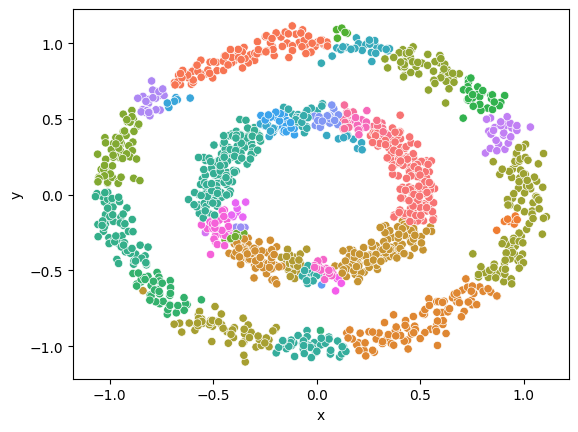

In [61]:
df = sklearn_scatter_to_df(noisy_circles, result[4])

plot = sns.scatterplot(df, x='x', y='y', hue='cluster')
plot.get_legend().remove()

## Step 8

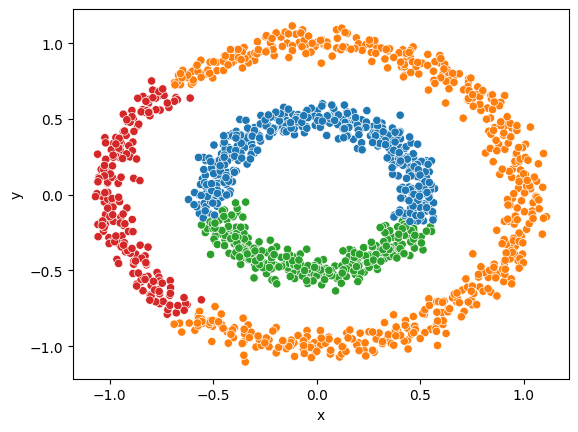

In [62]:
df = sklearn_scatter_to_df(noisy_circles, result[7])

plot = sns.scatterplot(df, x='x', y='y', hue='cluster')
plot.get_legend().remove()

## Step 9

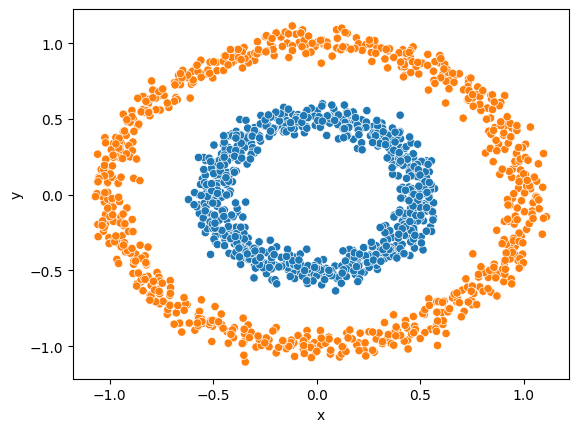

In [63]:
df = sklearn_scatter_to_df(noisy_circles, result[8])

plot = sns.scatterplot(df, x='x', y='y', hue='cluster')
plot.get_legend().remove()